# Predicting the Senate
In this notebook, I use data on previous Senate races to make predictions about the upcoming elections. The data come from 'election-dataset.csv,' which is outputted by 'create-election-dataset.py.'

## Election Data

To start, we will load the data and take a look at the available features.

In [1]:
import pandas as pd

df = pd.read_csv('data/election-dataset.csv',header=[0,1])
df.columns = pd.MultiIndex.from_tuples([(x[0],'') if 'Unnamed' in x[1] else x for x in df.columns ])
df.columns = [x[0]+x[1] for x in df.columns]

The columns tell us the state and year of the election as well as the state's population, and the incumbency, donations, votes and election result for both the Democratic and Republican candidates. The data exlude elections won by a third party.

In [2]:
print('There are {} observations. \n'.format(df.shape[0]))
print('The dataset includes features for '+', '.join(set([x.replace('REP','').replace('DEM','') for x in df.columns]))+'. \n')

There are 239 observations. 

The dataset includes features for spending, incumbent, name, year, winner, votes, state, population. 



Let's look through the available columns. The data cover the elections that took place every two years from 2002-2018.

In [3]:
df['year'].value_counts(sort=False)

2002    31
2006    31
2008    29
2010    29
2012    31
2014    28
2016    32
2018    28
Name: year, dtype: int64

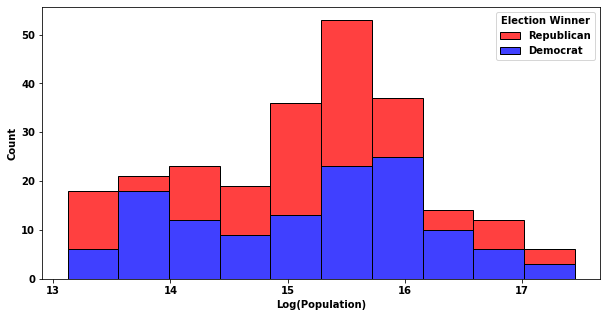

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

df['Election Winner'] = df['winnerDEM'].map({1:'Democrat',0:'Republican'})
df['logpopulation'] = np.log(df['population'])

plt.figure(figsize=(10,5))
sns.histplot(data=df,x='logpopulation', hue='Election Winner',multiple="stack",hue_order=['Republican','Democrat'],palette=['red','blue'])
plt.xlabel('Log(Population)')
plt.show()

It's difficult to see any clear relationship between state population and the outcome of elections. Let's move on and look at the incumbency features.

Out of the 239 elections, 88 involved an incumbent Republican and 104 involved an incumbent Democrat. 



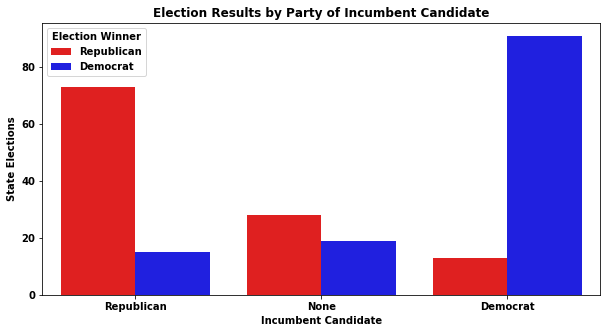

In [5]:
inc_dem = df['incumbentDEM'].sum().astype(int)
inc_rep = df['incumbentREP'].sum().astype(int)
print('Out of the {} elections, {} involved an incumbent Republican and {} involved an incumbent Democrat. \n'.format(df.shape[0],inc_rep,inc_dem))

incumb = (df['incumbentDEM'] - df['incumbentREP']).map({0.0:'None',-1.0:'Republican',1.0:'Democrat'})

plt.figure(figsize=(10,5))
sns.countplot(x=incumb, hue=df['Election Winner'],order=['Republican','None','Democrat'],
              hue_order=['Republican','Democrat'],palette=['red','blue'])
plt.title('Election Results by Party of Incumbent Candidate')
plt.xlabel('Incumbent Candidate')
plt.ylabel('State Elections')
plt.show()

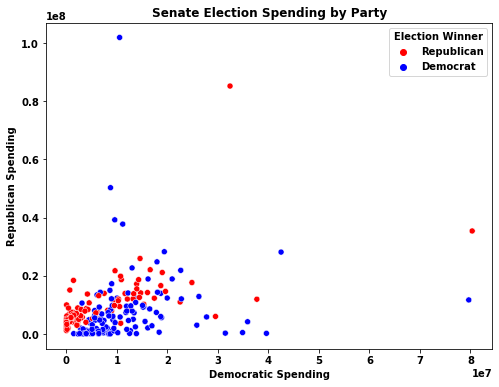

In [6]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['spendingDEM'],y=df['spendingREP'], hue=df['Election Winner'],
              hue_order=['Republican','Democrat'],palette=['red','blue'])
plt.xlabel('Democratic Spending')
plt.ylabel('Republican Spending')
plt.title('Senate Election Spending by Party')
plt.show()

As we might expect, the candidates who spend more money tend to win more. However, it's interesting that the Republican and Democrat who spent the most of any other candidate both lost their elections. Let's take a closer look at those extreme elections.

In [7]:
maxrep = df[df['spendingREP']==df['spendingREP'].max()].iloc[0]
print('The most campaign spending by a Republican was by {} in {} in {}, who was defeated by {}.'.format(maxrep['nameREP'],maxrep['state'],
                                                                                                      maxrep['year'],maxrep['nameDEM']))

The most campaign spending by a Republican was by McMahon, Linda E. in CT in 2012, who was defeated by Murphy, Christopher S..


Dem. Chris Murphy was able to raise more from individual contributions, but his challenger Rep. Linda McMahon, whose family owns the WWE, made large personal loans to her campaign which allowed her to greatly outspend Murphy (https://www.journalinquirer.com/politics_and_government/mcmahon-outspends-murphy-5-1/article_ae70328c-025b-59b5-b10d-11e32b3bd524.html).

In [8]:
maxdem = df[df['spendingDEM']==df['spendingDEM'].max()].iloc[0]
print('The most campaign spending by a Democrat was by {} in {} in {}, who was defeated by {}.'.format(maxdem['nameDEM'],maxdem['state'],
                                                                                                      maxdem['year'],maxdem['nameREP']))

The most campaign spending by a Democrat was by O'Rourke, Beto in TX in 2018, who was defeated by Cruz, Ted.


An unusually close Texas race in 2018 led to Beto O'Rourke's high campaign spending. After seeing that a Democrat had a chance to win in typically Republican-led Texas, Democratic Super PACs started donating millions of dollars to support O'Rourke (https://www.texastribune.org/2018/11/06/texas-elections-outside-spending/).

The result of the previous election will likely help us predict the next one. Let's create a lag variables for votes and wins to see if there's any relationship with the election outcome.

In [9]:
df = df.sort_values(by=['state','year'])
grouped = df.groupby(['state'])
df['lagvotesDEM'] = grouped.shift(1)['votesDEM']
df['lagvotesREP'] = grouped.shift(1)['votesREP']
df['lagwinnerDEM'] = grouped.shift(1)['winnerDEM']

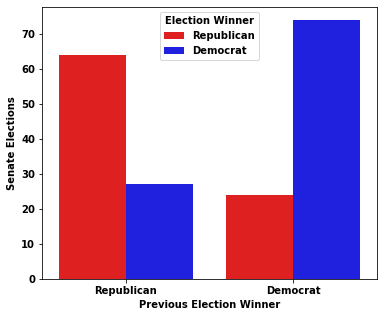

In [10]:
lagwin = df['lagwinnerDEM'].map({1:'Democrat',0:'Republican'})

plt.figure(figsize=(6,5))
sns.countplot(data=df,x=lagwin,hue=df['Election Winner'],palette=['red','blue'])
plt.xlabel('Previous Election Winner')
plt.ylabel('Senate Elections')
plt.show()

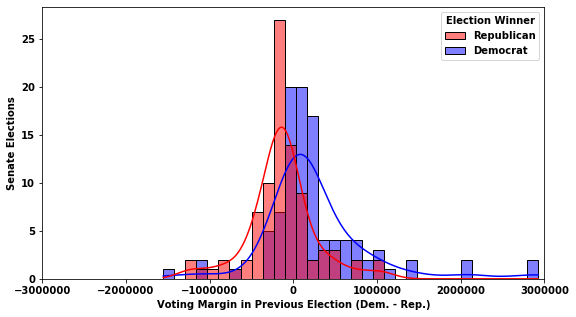

In [11]:
df['lagvotesMargin'] = df['lagvotesDEM'] - df['lagvotesREP']

plt.figure(figsize=(9,5))
sns.histplot(data=df, x='lagvotesMargin',hue='Election Winner', palette=['red','blue'],kde=True)
maxlag = np.round(np.abs(df['lagvotesMargin']).max(),-6)
plt.xlim(-maxlag,maxlag)
plt.ylabel('Senate Elections')
plt.xlabel('Voting Margin in Previous Election (Dem. - Rep.)')
plt.show()

As expected, the party that won the previous election tends to win the next one. By looking at the lagged voting margins, we also see that a higher margin of victory often foreshadows a better result for the party in the next election.

## Models
We can now use the data to create a model that predicts Senate elections.

We'll choose the features we want to use, then split the dataset into a training and test set. Unfortunately, we have to drop a few observations for early elections that have missing lag variables.

In [12]:
df['spendingMargin'] = df['spendingDEM'] - df['spendingREP']
df['lagvotesMarginPerc'] = df['lagvotesMargin'] / (df['lagvotesDEM'] + df['lagvotesREP'])

df_model = df.dropna(axis=0)
print('The dataframe shape now has {} observations.'.format(df.shape[0]))

X = df_model[['year','logpopulation','incumbentDEM','incumbentREP','spendingMargin','lagvotesMarginPerc','lagwinnerDEM']]
y = df_model['winnerDEM']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The dataframe shape now has 239 observations.


We will train three different models: logistic regression, random forest classifier, and SVM. At the end, we can use them to predict some of the current Senate races.

In [13]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_train,y_train)
lmpreds = lm.predict(X_test)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_true=y_test, y_pred=lmpreds)
print('Logistic regression confusion matrix: \n', mat,'\n')
print('Accuracy: \n',np.round((mat[1,1]+mat[0,0])/mat.sum(),2))

Logistic regression confusion matrix: 
 [[18  9]
 [ 4 26]] 

Accuracy: 
 0.77


In [14]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1234)
rf.fit(X_train,y_train)
rfpreds = rf.predict(X_test)

mat = confusion_matrix(y_true=y_test, y_pred=rfpreds)
print('Random Forest confusion matrix: \n', mat,'\n')
print('Accuracy: \n',np.round((mat[1,1]+mat[0,0])/mat.sum(),2))

Random Forest confusion matrix: 
 [[22  5]
 [ 8 22]] 

Accuracy: 
 0.77


In [15]:
# Support Vector Machine
from sklearn.svm import LinearSVC
sv = LinearSVC(random_state=123)
sv.fit(X_train,y_train)
svpreds = sv.predict(X_test)

mat = confusion_matrix(y_true=y_test, y_pred=svpreds)
print('SVM confusion matrix: \n', mat,'\n')
print('Accuracy: \n',np.round((mat[1,1]+mat[0,0])/mat.sum(),2))

SVM confusion matrix: 
 [[18  9]
 [ 4 26]] 

Accuracy: 
 0.77


Now let's use the models to make predictions on the South Caroline Senate race between incumbent Rep. Senator Lindsey Graham and Dem. Jaime Harrison. As of now, Harrison has outraised Graham by \\$86 million to \\$58 million. We can use these figures to estimate the spending margin and we will make some other assumptions, like using the same population number from the previous South Carolina election. 
(https://apnews.com/article/election-2020-donald-trump-senate-elections-confirmation-hearings-jaime-harrison-c92f443c3f02dbe03276a01eb8f7450f)

In [16]:
columns = ['year','logpopulation','incumbentDEM','incumbentREP','spendingMargin','lagvotesMarginPerc','lagwinnerDEM']
sc = df[df['state']=='SC']
sc = sc[sc['year']==sc['year'].max()]
data = [[2020, sc['logpopulation'].iloc[0], 0, 1, 28000000, 
         (sc['lagvotesDEM'].iloc[0] - sc['lagvotesREP'].iloc[0]) / (sc['lagvotesDEM'].iloc[0] + sc['lagvotesREP'].iloc[0]),0]]
data = pd.DataFrame(data,columns=columns)
X_sc = scaler.transform(data)

In [17]:
sc_lm = lm.predict(X_sc)
sc_rf = rf.predict(X_sc)
sc_sv = sv.predict(X_sc)
def modres(x):
    if x[0]==0:
        return 'Lose'
    elif x[0]==1:
        return 'Win'
print('Model predictions for Jaime Harrison: \n',modres(sc_lm),',', modres(sc_rf),',', modres(sc_sv))
print('Jaime Harrison probability of winning: \n',np.round(lm.predict_proba(X_sc)[0][1],4))

Model predictions for Jaime Harrison: 
 Lose , Lose , Lose
Jaime Harrison probability of winning: 
 0.045


All three models predicted that Rep. Lindsey Graham will win the election. The logit model predicts that Jaime Harrison only has about a 5% chance of winning.

Now we will try using the neural network model described in Rumelhart et al. (1986). The code for this model is in the "nnetwork.py" file. This model uses back-propogating errors to repeatedly train itself and improve its fit on the training data. (Rumelhart, D., Hinton, G. & Williams, R., Learning representations by back-propagating errors. Nature 323, 533–536 (1986). http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf)

 We will first split off a validation dataset from the training data to help us decide when to stop training. Then we construct the model using layers of neurons.

In [18]:
import nnetwork

X_n_train, X_n_validate, y_n_train, y_n_validate = train_test_split(X_train, y_train.to_numpy(), test_size=0.25, random_state=1234)
X_n_test = X_test
y_n_test = y_test.to_numpy()

In [19]:
num_features = X_n_train.shape[1]

inputLayer = nnetwork.Layer(num_neurons = num_features, input_data = X_n_train, validation_data = X_n_validate, test_data = X_test)
hiddenLayer1 = nnetwork.Layer(num_neurons=25, layer_below=inputLayer)
hiddenLayer2 = nnetwork.Layer(num_neurons=25, layer_below=hiddenLayer1)
outputLayer = nnetwork.Layer(num_neurons=1, layer_below=hiddenLayer2)

model = nnetwork.NeuralNet(layers=[inputLayer, hiddenLayer1, hiddenLayer2, outputLayer])

Now we can train the model. It will propogate the errors on the training data back through the model and incrementally adjust itself for 50,000 iterations, or epochs, or until the model's fit on the validation data stops improving.

In [20]:
model.learn(num_epochs=50000, y_train=y_n_train, y_validate=y_n_validate, y_test=y_test)

After the model is trained, we can look at how its error on the training and validation datasets improved during its training.

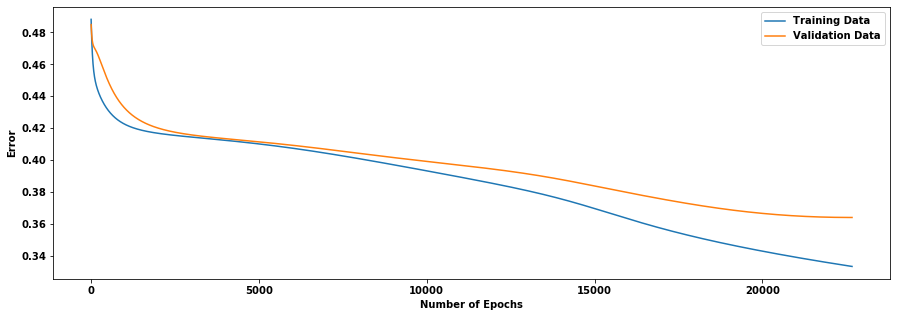

In [21]:
plt.figure(figsize=(15,5))
plt.plot(model.errors)
plt.plot(model.valerrors)
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.legend(['Training Data','Validation Data'])
plt.show()

The model stopped training itself after about 25,000 epochs because the error on the validation data stopped improving. Now let's see how this model performs on the testing data.

In [22]:
modelpreds = model.layers[-1].get_results()[:,0].round()

mat = confusion_matrix(y_true=y_test, y_pred=modelpreds)
print('Rumelhart et al. confusion matrix: \n', mat,'\n')
print('Accuracy: \n',np.round((mat[1,1]+mat[0,0])/mat.sum(),2))

Rumelhart et al. confusion matrix: 
 [[21  6]
 [ 8 22]] 

Accuracy: 
 0.75


The model performed nearly the same as the other three models. It predicted the correct outcome of the Senate races 75% of the time.

In [23]:
inputLayer.input_data = X_sc
for neuron_idx in range(inputLayer.num_neurons):
    inputLayer.neurons[neuron_idx].output = X_sc[:,neuron_idx]
hiddenLayer1.activate_layer()
hiddenLayer2.activate_layer()
outputLayer.activate_layer()
print('Rumelhart et al. model prediction for Jaime Harrison: \n',modres(np.round(outputLayer.get_output())[0]))

Rumelhart et al. model prediction for Jaime Harrison: 
 Lose


The upcoming elections will provide us with more training data which will improve the performance of these models in the future.